<a href="https://colab.research.google.com/github/DietzscheNostoevsky/Learning_Pytorch/blob/main/04_Pytorch_Custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Custom Datasets

- A custom dataset is a collection of data relating to a specific problem we are working on.
- Á custom dataset can be comprised of almost anything.

*PyTorch includes many existing functions to load in various custom datasets in the [`TorchVision`](https://pytorch.org/vision/stable/index.html), [`TorchText`](https://pytorch.org/text/stable/index.html), [`TorchAudio`](https://pytorch.org/audio/stable/index.html) and [`TorchRec`](https://pytorch.org/torchrec/) domain libraries.*

But sometimes these existing functions may not be enough.

In that case, we can always subclass `torch.utils.data.Dataset` and customize it to our liking.

# Notebook Workflow 


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="building a pipeline to load in food images and then building a pytorch model to classify those food images" width=800 />

we're going to be using our own dataset of pizza, steak and sushi images.

The goal will be to load these images and then build a model to train and predict on them.

 We'll use `torchvision.datasets` as well as our own custom Dataset class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them


# 0. Setting up devive agnostic code

In [66]:
import torch
from torch import nn 

torch.__version__

'2.0.1+cu118'

In [67]:
# Setting up device agnostic code 

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Getting data 

Using a subset of food images data from Food101 dataset, which contains 101 food classes, each containing 1000 images per class, total 101,000 images. Each class containing 750 train, 250 test images.  

We are using only random 10% images per class, for 3 classes   
    - Pizza  
    - Steak   
    - Sushi   



## Original Data Source 

Original Data Resources :
* Original [Food101 dataset and paper website](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).
* [`torchvision.datasets.Food101`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) - the version of the data downloaded for this notebook.
* [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) - a notebook used to format the Food101 dataset to use for this notebook.
* [`data/pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) - the zip archive of pizza, steak and sushi images from Food101, created with the notebook linked above.


In [68]:
import requests
import zipfile
from pathlib import Path
from tqdm.auto import tqdm

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    download_url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

    # Get more data for the same classes 
    #download_url = "https://drive.google.com/file/d/15ruMV4CxcxWomYA9igJ8eERLAUFN8R30/view?usp=sharing"
    download_file = data_path / "pizza_steak_sushi.zip"
    
    response = requests.get(download_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    progress_bar = tqdm(total=total_size, unit='B', unit_scale=True, desc='Downloading')
    
    with open(download_file, "wb") as f:
        for data in response.iter_content(chunk_size=4096):
            f.write(data)
            progress_bar.update(len(data))
    
    progress_bar.close()
    
    # Unzip pizza, steak, sushi data
    unzip_path = data_path / "pizza_steak_sushi.zip"
    extract_path = image_path

    # It doesn't checks if file is actually downloaded or not, so if zip file 
    # is thorowing an error, check if the file is actually being downloaded or not, and 
    # zip is executing only after file is downloaded. 
    
    with zipfile.ZipFile(unzip_path, "r") as zip_ref:
        file_list = zip_ref.namelist()
        progress_bar = tqdm(file_list, desc='Extracting')
        
        for file in progress_bar:
            zip_ref.extract(file, extract_path)
        
    progress_bar.close()

    print("Download and extraction complete!")


data/pizza_steak_sushi directory exists.


# 2. Data Prepration

***What Am I trying to solve ?*** 

We have images of pizza, steak and sushi in standard image classification format.

Image classification format contains separate classes of images in seperate directories titled with a particular class name.

For example, all images of `pizza` are contained in the `pizza/` directory.

This format is popular across many different image classification benchmarks, including [ImageNet](https://www.image-net.org/) (of the most popular computer vision benchmark datasets).

The goal will be to **take this data storage structure and turn it into a dataset usable with PyTorch**.

## Setting up directories

In [69]:
# Helper function to see what is inside the directory 
# using os.walk()
import os


def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [70]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [71]:
# Setting up training and testing paths 

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Image Visualization

1. Get all of the image paths using [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) to find all of the files ending in `.jpg`. 
2. Pick a random image path using Python's [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice).
3. Get the image class name using [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent).
4. And since we're working with images, we'll open the random image path using [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open) (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.


Random image path: data/pizza_steak_sushi/test/sushi/2715127.jpg
Image class: sushi
Image height: 512
Image width: 512


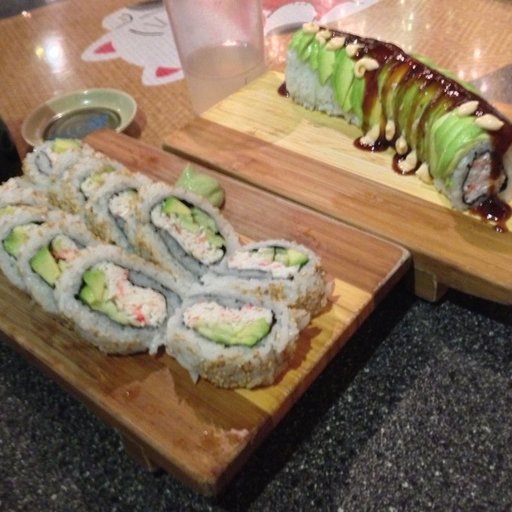

In [72]:
import random
from PIL import Image

random.seed(37)

# Gettting all image paths 
image_path_list = list(image_path.glob("*/*/*.jpg"))

# getting random image path 
random_image_path = random.choice(image_path_list)

# getting image class from path name 

image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

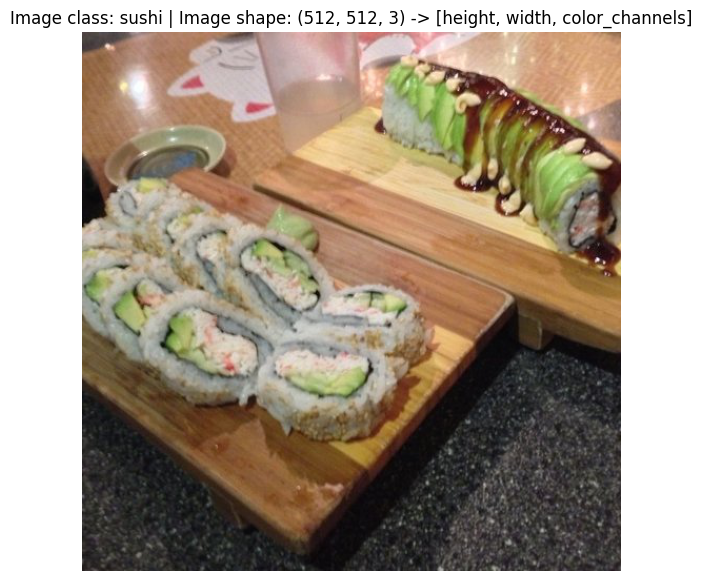

In [73]:
# Using Numpy 
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# 3. Transforming Data

To load in inside PyTorch

Before we can use our image data with PyTorch we need to:

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader` for short.

In [74]:
import torch
from torch.utils.data import DataLoader 
from torchvision import datasets, transforms 

## 3.1 Transforming Data with `torchvision.transforms`

Let's write a series of transform steps that:
1. Resize the images using [`transforms.Resize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) (from about 512x512 to 64x64, the same shape as the images on the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/)).
2. Flip our images randomly on the horizontal using [`transforms.RandomHorizontalFlip()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip) (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using [`transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor).

We can compile all of these steps using [`torchvision.transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose).

In [75]:
# Write transforms for imafge 

data_transform = transforms.Compose([
    #resize the image 
    transforms.Resize(size=(64,64)),
    # flipping images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),# prob of flip 
    # turining image into a torch Tensor 
    transforms.ToTensor()# this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])
data_transform

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

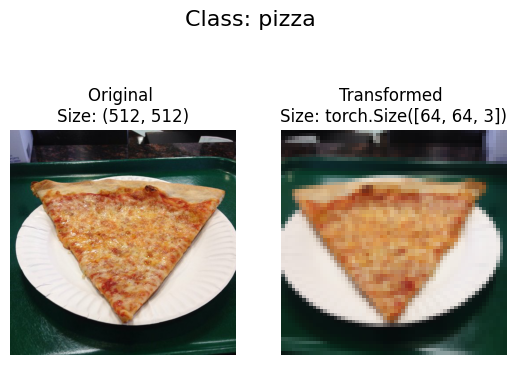

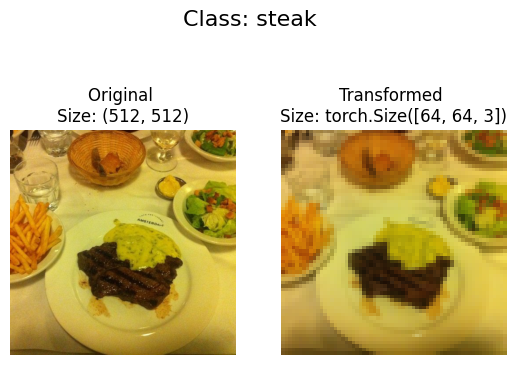

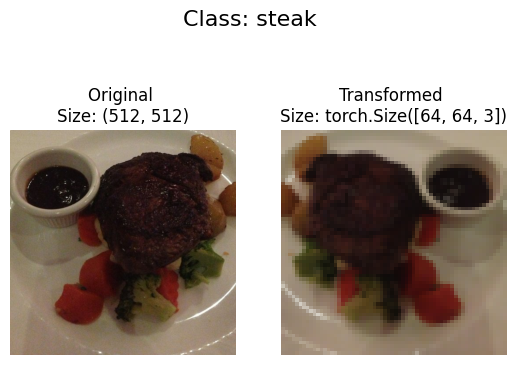

In [76]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths :
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

# 4. Option 1: Loading Image Data Using ImageFolder

Turn our image data into a `Dataset` capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder).

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

In [77]:
# using ImageFolder to create datasets

from torchvision import datasets

# Similar to this code 
# ---------------------------------------------------------------
#train_data = datasets.FashionMNIST(
#    root="data", # where to download data to?
#    train=True, # get training data
#    download=True, # download data if it doesn't exist on disk
#    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
#    target_transform=None) # you can transform labels as well
# ---------------------------------------------------------------

train_data = datasets.ImageFolder(
    root=train_dir, # target folder of images 
    transform=data_transform, # transforms to perform on data (images)                             
    target_transform=None # transforms to perform on labels (if necessary)
    )
test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [78]:
# getting class labels as list 
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [79]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [80]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [81]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

## Plotting using `matplotlib`

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


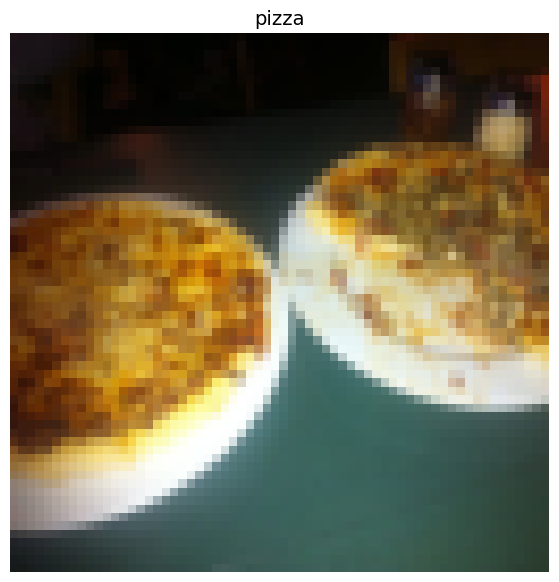

In [82]:
# # Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0) # from CHW to HWC

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

## Turning Loaded images into `DataLoader`

Turning our Dataset's into `DataLoader`'s makes them iterable so a model can go through learn the relationships between samples and targets (features and labels)

In [83]:
os.cpu_count()

2

In [84]:
# turinng train and test Datasets into DataLoaders 

from torch.utils.data import DataLoader
import os
# ----from MNIST example-------------
#
# train_dataloader = DataLoader(train_data, # dataset to turn into iterable
#    batch_size=BATCH_SIZE, # how many samples per batch? 
#   shuffle=True) # shuffle data every epoch?
#
#----------------------------------------

train_dataloader = DataLoader(train_data,
                              batch_size=1, # using a batch size of 1 effectively turns
                                            # the algorithm into Stochastic Gradient Descent (SGD)
                                            # instead of Mini-batch GD
                              num_workers=os.cpu_count(), ## how many subprocesses to use for data loading? (higher = more)
                              shuffle=True
                              )

test_dataloader = DataLoader(test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # no need to shuffle test data

print(F"train_dataloader : {train_dataloader}")
print(F"test_dataloader : {test_dataloader}")

train_dataloader : <torch.utils.data.dataloader.DataLoader object at 0x7fa67d8b3310>
test_dataloader : <torch.utils.data.dataloader.DataLoader object at 0x7fa67d8b3b80>


In [85]:
# Checing out iterables 

img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# 5. Option 2: Loading Image Data with a Custom `Dataset`

- write code to load your data in the format you'd like it

- Replicating `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset` (the base class for all `Dataset`'s in PyTorch). 


In [86]:
# importing required dependencies 

import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset 
from torchvision import transforms 
from typing import Tuple, Dict, List  


# The line above imports specific type hints from the typing module

# The `typing` module provides built-in types and classes for type annotations
# In this case, Tuple, Dict, and List types are being imported

# These type hints are used to indicate the expected types of function arguments,
# return values, and variables

# Tuple, Dict, and List allow specifying the structure and types of tuples,
# dictionaries, and lists

# For example, Tuple[str, int] indicates a tuple with a string as the first element
# and an integer as the second element

# Similarly, Dict[str, int] represents a dictionary with string keys and integer values

# List[int] represents a list of integers

# Using these type hints improves code readability and enables type checking tools
# to catch potential type errors

In [87]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## Creating helper function to get class names 

1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dictionary of numerical labels, one for each class.

In [88]:
# tewting an example 
# Setup path for target directory 

target_directory = train_dir 
print(F"target directory: {target_directory}")

# get class names from the target directory 

class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])

target directory: data/pizza_steak_sushi/train


In [89]:
a = [entry for entry in list(os.scandir(image_path / "train"))]
print(a)

[<DirEntry 'steak'>, <DirEntry 'sushi'>, <DirEntry 'pizza'>]


In [90]:
print(a[1].name)

sushi


In [91]:
class_names_found

['pizza', 'steak', 'sushi']

In [92]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [93]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## Create custom `Dataset` to replicate `ImageFolder`


1. Subclass `torch.utils.data.Dataset`.
2. Initialize our subclass with a `targ_dir` parameter (the target data directory) and `transform` parameter (so we have the option to transform our data if needed).
3. Create several attributes for `paths` (the paths of our target images), `transform` (the transforms we might like to use, this can be `None`), `classes` and `class_to_idx` (from our `find_classes()` function).
4. Create a function to load images from file and return them, this could be using `PIL` or [`torchvision.io`](https://pytorch.org/vision/stable/io.html#image) (for input/output of vision data). 
5. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the `Dataset`, this is recommended but not required. This is so you can call `len(Dataset)`.
6. Overwrite the `__getitem__` method of `torch.utils.data.Dataset` to return a single sample from the `Dataset`, this is required.

In [94]:
# Writing a custom dataset class ( inhereting from torch.utils.data.Dataset )

from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset

class ImageFolderCustom(Dataset):

    # 2. INirializing with a targ_dir and trasnform(optional) parameter : 
    def __init__(self, targ_dir, transform=None) -> None:

        # 3. Create class attributes 
        # get all images paths 

        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # Update this for png or jpeg
        #Setting up transformers
        self.transform = transform
        #create classes and class_to_ind attributes 
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Function to load images 
    def load_image(self, index:int) -> Image.Image:
        """
        Opens an image via a path and returns it
        """
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)

    def __len__(self) -> int:
        "Returns total num of samples"
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label(X, y). "
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]
        
        # Transform in necessary

        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

    



### Creating Transforms

In [95]:
# Augmenting training data

train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### Testing custom dataset loading class

In [96]:
print(train_dir, "\n", test_dir)

data/pizza_steak_sushi/train 
 data/pizza_steak_sushi/test


In [97]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom


(<__main__.ImageFolderCustom at 0x7fa67d8b3640>,
 <__main__.ImageFolderCustom at 0x7fa67d8b3e20>)

In [98]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [99]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [100]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [101]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


## creating function to display random images 

Createing a helper function called `display_random_images()` that helps us visualize images in our `Dataset'`s.

Specifically, it'll:
1. Take in a `Dataset` and a number of other parameters such as `classes` (the names of our target classes), the number of images to display (`n`) and a random seed. 
2. To prevent the display getting out of hand, we'll cap `n` at 10 images.
3. Set the random seed for reproducible plots (if `seed` is set). 
4. Get a list of random sample indexes (we can use Python's `random.sample()` for this) to plot.
5. Setup a `matplotlib` plot.
6. Loop through the random sample indexes found in step 4 and plot them with `matplotlib`.
7. Make sure the sample images are of shape `HWC` (height, width, color channels) so we can plot them.

In [102]:
# 1. Take in a Dataset as well as a list of class names

def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed:int = None):
    # 2. Adjust display if n too high
    if n > 10 :
        n = 10
        display_shape = False 
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Settnig random seed 
    if seed:
        random.seed(seed)
    
    # 4. get random sample index: 
    random_samples_idx = random.sample(range(len(dataset)), k=n) # Return a k length list of unique elements
                                                                # chosen from the population sequence. 
                                                                # Used for random sampling without replacement.
    # 5. Setup Plot
    plt.figure(figsize=(16,8))

    # 6. Loop through samples and display random samples 
    from tqdm.auto import tqdm
    for i, targ_sample in tqdm(enumerate(random_samples_idx)):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1,2,0)

        # plot adjusted samples 
        
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

0it [00:00, ?it/s]

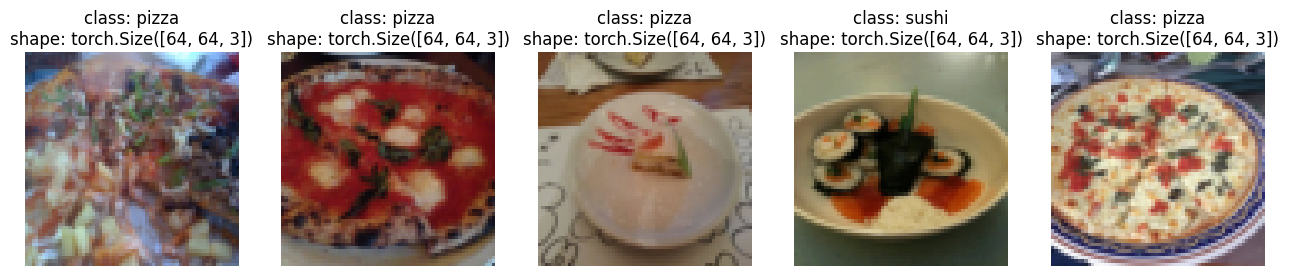

In [103]:
# testing 

display_random_images(train_data,
                      classes=class_names,
                      n=5,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


0it [00:00, ?it/s]

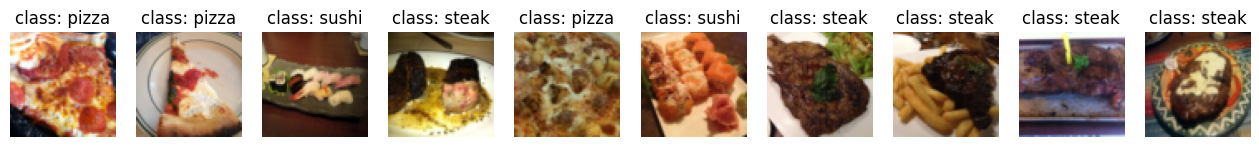

In [104]:
display_random_images(train_data_custom, 
                      n=12, 
                      classes=class_names,
                      seed=None,
                      display_shape=True)

## Turn custom loaded images into `DataLoader`'s

Because our custom `Dataset`'s subclass `torch.utils.data.Dataset`, we can use them directly with `torch.utils.data.DataLoader()`.

And we can do using very similar steps to before except this time we'll be using our custom created `Dataset`'s.

In [105]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fa67eda0880>,
 <torch.utils.data.dataloader.DataLoader at 0x7fa67eda1360>)

In [106]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# Data Augmentation

Machine learning is all about harnessing the power of randomness and research shows that random transforms (like [`transforms.RandAugment()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#randaugment) and [`transforms.TrivialAugmentWide()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide)) generally perform better than hand-picked transforms.

The idea behind [TrivialAugment](https://arxiv.org/abs/2103.10158) is... well, trivial. 

You have a set of transforms and you randomly pick a number of them to perform on an image and at a random magnitude between a given range (a higher magnitude means more instense).

The main parameter to pay attention to in `transforms.TrivialAugmentWide()` is `num_magnitude_bins=31`.

It defines how much of a range an intensity value will be picked to apply a certain transform, `0` being no range and `31` being maximum range (highest chance for highest intensity). 

We can incorporate `transforms.TrivialAugmentWide()` into `transforms.Compose()`.

Random transforms  
random, which means that the same transfomer instance will produce different result each time it transforms a given image.

In [107]:
from torchvision import transforms 

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data

test_augmentation = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])


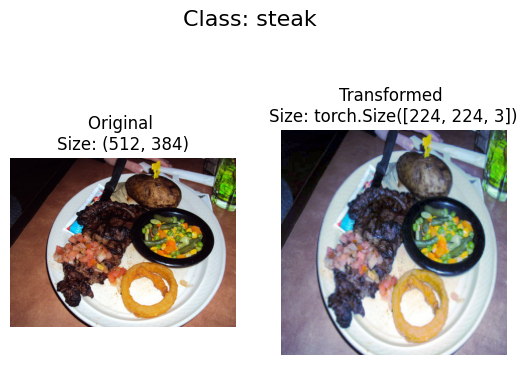

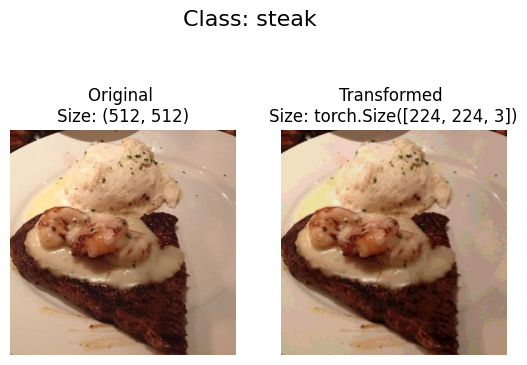

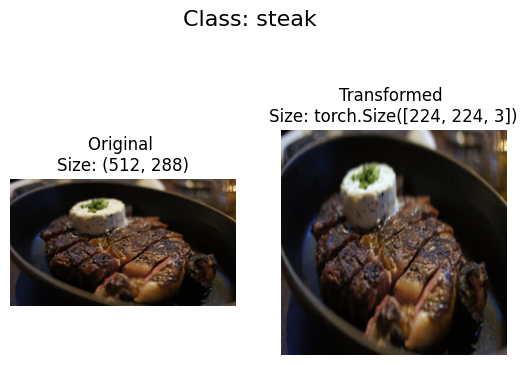

In [108]:
# Testing Augmentation 

image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot Random Images 
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

# Model 0 : TinyVGG without Data Augmentation

## Creating transfoems and loading data for Model 0

In [109]:
# create simple transform 

simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

1. Load the data, turning each of our training and test folders first into a `Dataset` with `torchvision.datasets.ImageFolder()` 
2. Then into a `DataLoader` using `torch.utils.data.DataLoader()`.
    * We'll set the `batch_size=32` and `num_workers` to as many CPUs on our machine (this will depend on what machine you're using).

In [110]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7fa67f02dd80>,
 <torch.utils.data.dataloader.DataLoader at 0x7fa67ef919f0>)

## Building a Model TinyVGG class

Color images with 3 channels 

In [111]:
import torch.nn 

class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),   # options = "valid" (no padding)
                                    # or "same" (output has same shape as input) 
                                    # or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.MaxPool2d(kernel_size=2,
                     stride=2)  # default stride value is same as kernel_size             
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)           
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)

        return x

torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0



TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## Try a forward pass on a single image (to test the model)

A good way to test a model is to do a forward pass on a single piece of data.

It's also handy way to test the input and output shapes of our different layers.

To do a forward pass on a single image, let's:
1. Get a batch of images and labels from the `DataLoader`.
2. Get a single image from the batch and `unsqueeze()` the image so it has a batch size of `1` (so its shape fits the model).
3. Perform inference on a single image (making sure to send the image to the target `device`).
4. Print out what's happening and convert the model's raw output logits to prediction probabilities with `torch.softmax()` (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with `torch.argmax()`.

In [112]:
# getting a batch of images 

img_batch, label_batch = next(iter(train_dataloader_simple))

# getting single image 
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

#performing model eval 
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}") 

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0699, 0.0681, 0.0286]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3381, 0.3375, 0.3244]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
2


### using `torchinfo` to get idea about shapes going through the model

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

Printing out our model with `print(model)` gives us an idea of what's going on with our model.

And we can print out the shapes of our data throughout the `forward()` method.

However, a helpful way to get information from our model is to use [`torchinfo`](https://github.com/TylerYep/torchinfo).

`torchinfo` comes with a `summary()` method that takes a PyTorch model as well as an `input_shape` and returns what happens as a tensor moves through your model.


In [113]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─MaxPool2d: 2-4                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-5                       [1, 10, 32, 32]           910
│    └─ReLU: 2-6                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-7                       [1, 10, 32, 32]           910
│    └─ReLU: 2-8                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-9                    [1, 10, 16, 16]           --
├─Sequential: 1-3                        [1, 3]                    --
│    └─Flat

## Creating train and test loop Functions 

Specifically, we're going to make three functions:
1. `train_step()` - takes in a model, a `DataLoader`, a loss function and an optimizer and trains the model on the `DataLoader`.
2. `test_step()` - takes in a model, a `DataLoader` and a loss function and evaluates the model on the `DataLoader`.
3. `train()` - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

In [114]:
# Train Step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    from tqdm.auto import tqdm
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X,y) in (enumerate(dataloader)):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

print(train_step)

<function train_step at 0x7fa67f0840d0>


In [115]:
# Test Step 
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    from tqdm.auto import tqdm
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in (enumerate(dataloader)):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    return test_loss, test_acc      

print(test_step)

<function test_step at 0x7fa67f085000>




### Creating a `train()` function to combine `train_step()` and `test_step()`



Put our `train_step()` and `test_step()` functions together.

To do so, we'll package them up in a `train()` function.

This function will train the model as well as evaluate it.

Specificially, it'll:
1. Take in a model, a `DataLoader` for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for `train_loss`, `train_acc`, `test_loss` and `test_acc` values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metrics each epoch.
6. Return the filled

To keep track of the number of epochs we've been through, let's import `tqdm` from `tqdm.auto` ([`tqdm`](https://github.com/tqdm/tqdm) is one of the most popular progress bar libraries for Python and `tqdm.auto` automatically decides what kind of progress bar is best for your computing environment, e.g. Jupyter Notebook vs. Python script).

In [116]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

print(train)   


<function train at 0x7fa6b6bd04c0>


## Train and Evaluate Model 0

In [117]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1081 | train_acc: 0.2617 | test_loss: 1.1415 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0810 | train_acc: 0.4258 | test_loss: 1.1677 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1181 | train_acc: 0.2930 | test_loss: 1.1723 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0805 | train_acc: 0.4258 | test_loss: 1.1222 | test_acc: 0.2812
Epoch: 5 | train_loss: 1.0271 | train_acc: 0.5391 | test_loss: 1.1072 | test_acc: 0.3523
Epoch: 6 | train_loss: 1.0319 | train_acc: 0.4492 | test_loss: 1.0747 | test_acc: 0.4025
Epoch: 7 | train_loss: 0.9740 | train_acc: 0.5352 | test_loss: 1.0939 | test_acc: 0.4744
Epoch: 8 | train_loss: 0.8103 | train_acc: 0.6758 | test_loss: 1.0184 | test_acc: 0.5047
Epoch: 9 | train_loss: 0.7973 | train_acc: 0.6562 | test_loss: 1.0360 | test_acc: 0.5350
Epoch: 10 | train_loss: 0.8176 | train_acc: 0.6680 | test_loss: 1.0409 | test_acc: 0.5246
Epoch: 11 | train_loss: 0.7832 | train_acc: 0.6836 | test_loss: 0.9802 | test_acc: 0.4943
Epoch: 12 | train_l

## Loss Curves

In [118]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [119]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

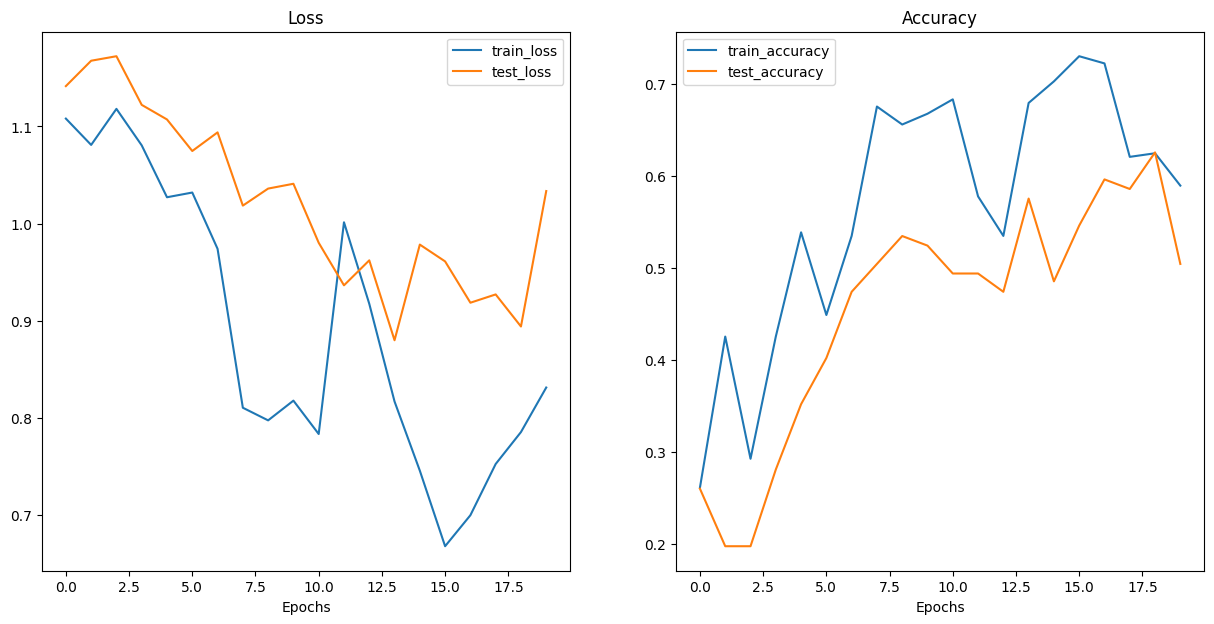

In [120]:
plot_loss_curves(model_0_results)


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="different training and test loss curves illustrating overfitting, underfitting and the ideal loss curves" width="800"/>

*Left: If your training and test loss curves aren't as low as you'd like, this is considered **underfitting**. *Middle:* When your test/validation loss is higher than your training loss this is considered **overfitting**. *Right:* The ideal scenario is when your training and test loss curves line up over time. This means your model is generalizing well. There are more combinations and different things loss curves can do, for more on these, see Google's [Interpreting Loss Curves guide](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic).*

# Model 1 : TinyVGG with Data Augmentation

## Data augmentation transform

In [121]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

## Creating train and test Dataset and Dataloader

In [122]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [123]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fa67f0e8550>,
 <torch.utils.data.dataloader.DataLoader at 0x7fa67d8b3b80>)

## Model 1 

In [124]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [125]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1077 | train_acc: 0.2500 | test_loss: 1.1051 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0775 | train_acc: 0.4258 | test_loss: 1.1413 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0780 | train_acc: 0.4258 | test_loss: 1.1725 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1204 | train_acc: 0.3047 | test_loss: 1.1451 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.1056 | train_acc: 0.3164 | test_loss: 1.1312 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.0777 | train_acc: 0.4531 | test_loss: 1.1394 | test_acc: 0.3229
Epoch: 7 | train_loss: 1.0608 | train_acc: 0.5469 | test_loss: 1.1319 | test_acc: 0.2917
Epoch: 8 | train_loss: 1.0726 | train_acc: 0.4570 | test_loss: 1.1153 | test_acc: 0.3324
Epoch: 9 | train_loss: 1.0811 | train_acc: 0.4180 | test_loss: 1.1041 | test_acc: 0.3229
Epoch: 10 | train_loss: 1.0019 | train_acc: 0.5820 | test_loss: 0.9997 | test_acc: 0.4943
Epoch: 11 | train_loss: 0.9788 | train_acc: 0.5664 | test_loss: 1.0218 | test_acc: 0.3428
Epoch: 12 | train_l

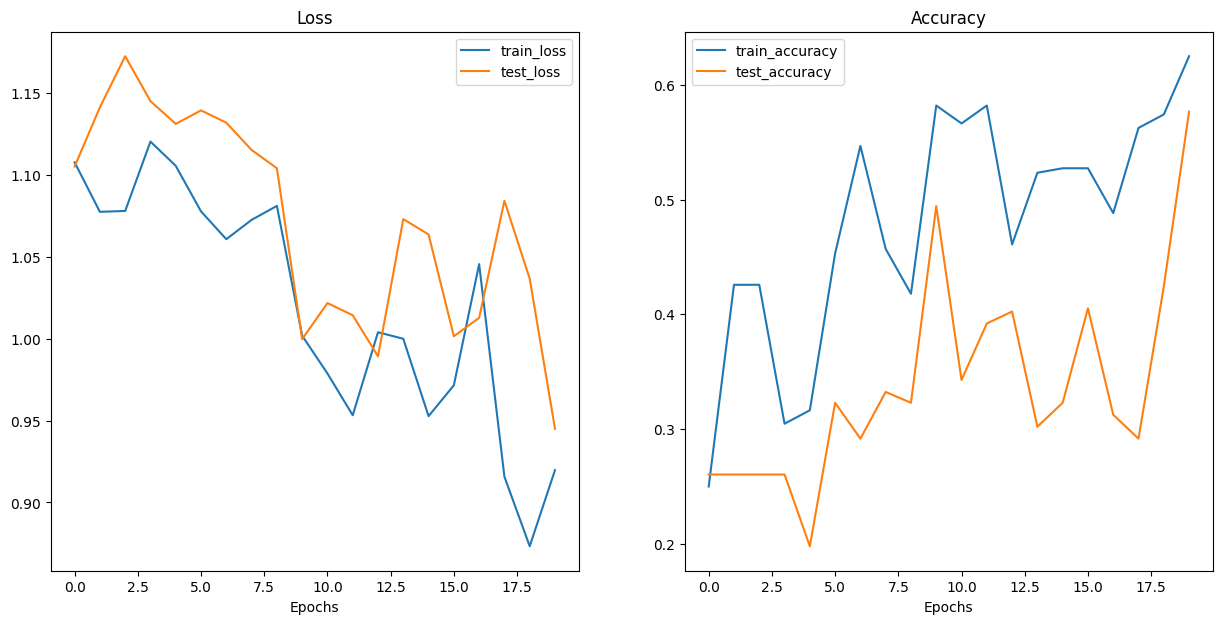

In [126]:
 plot_loss_curves(model_1_results)

# Comparing Model Results

In [127]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.108072,0.261719,1.141526,0.260417
1,1.080952,0.425781,1.167668,0.197917
2,1.118089,0.292969,1.172311,0.197917
3,1.080507,0.425781,1.122210,0.281250
4,1.027062,0.539062,1.107181,0.352273
5,1.031924,0.449219,1.074698,0.402462
6,0.973953,0.535156,1.093876,0.474432
7,0.810284,0.675781,1.018450,0.504735
8,0.797272,0.656250,1.035992,0.535038
9,0.817599,0.667969,1.040948,0.524621


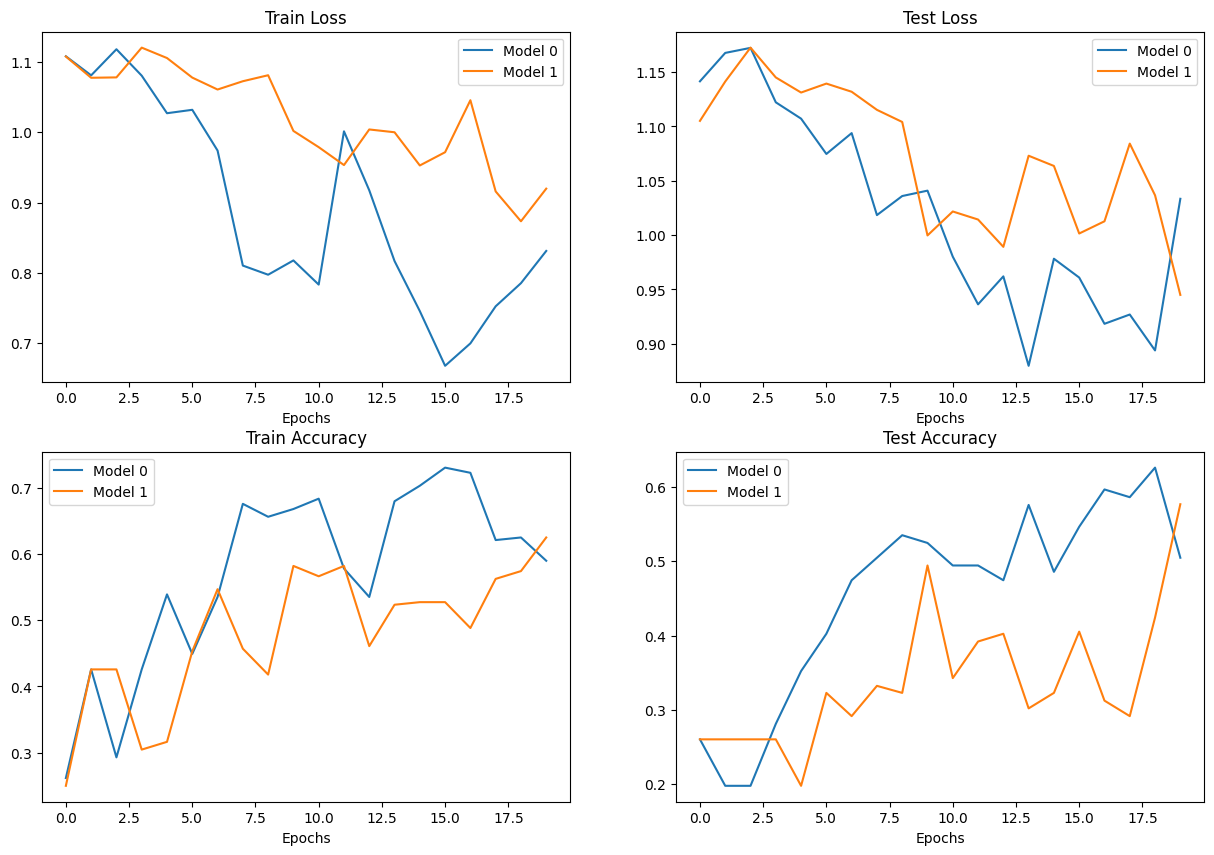

In [128]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

# Make a prediction on a custom image

In [129]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

## Loading custom image with PyTorch

In [130]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [131]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

## Predicting on custom images with a trained PyTorch model¶

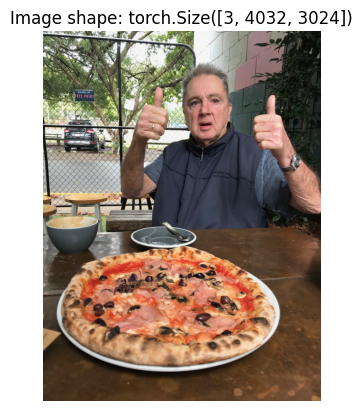

In [132]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [133]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [134]:
# The batch size dimention needs to be added, as model was trained on it 

model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])




> **Note:** What we've just gone through are three of the classical and most common deep learning and PyTorch issues:
> 1. **Wrong datatypes** - our model expects `torch.float32` where our original custom image was `uint8`.
> 2. **Wrong device** - our model was on the target `device` (in our case, the GPU) whereas our target data hadn't been moved to the target `device` yet.
> 3. **Wrong shapes** - our model expected an input image of shape `[N, C, H, W]` or `[batch_size, color_channels, height, width]` whereas our custom image tensor was of shape `[color_channels, height, width]`.
>
> Keep in mind, these errors aren't just for predicting on custom images. 
>
> They will be present with almost every kind of data type (text, audio, structured data) and problem you work with.

Now let's take a look at our model's predictions.

In [135]:
custom_image_pred

tensor([[ 0.1377, -0.4936, -0.4114]], device='cuda:0')

In [136]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1377, -0.4936, -0.4114]], device='cuda:0')
Prediction probabilities: tensor([[0.4741, 0.2522, 0.2738]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [137]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

In [138]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[0.4741, 0.2522, 0.2738]], device='cuda:0')

## Making a prediction function



Specifically, let's make a function that:
1. Takes in a target image path and converts to the right datatype for our model (`torch.float32`).
2. Makes sure the target image pixel values are in the range `[0, 1]`.
3. Transforms the target image if necessary.
4. Makes sure the model is on the target device.
5. Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model).
6. Converts the model's output logits to prediction probabilities.
7. Converts the prediction probabilities to prediction labels.
8. Plots the target image alongside the model prediction and prediction probability.


In [139]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

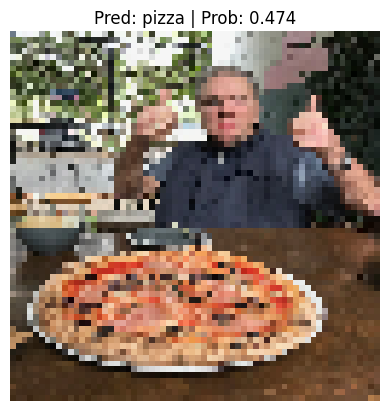

In [140]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)